In [ ]:
%matplotlib inline

In [ ]:
!pip install isoweek

import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
from isoweek import Week

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Colab Notebooks/kaggle-rossmann/dataset/rossmann/'
%cd '/content/drive/MyDrive/Colab Notebooks/kaggle-rossmann'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/kaggle-rossmann


In [ ]:
import pandas as pd
!pip install pandas_summary
from pandas_summary import DataFrameSummary

# Competencia de Kaggle

[ir a Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data)

[3er puesto](https://github.com/entron/entity-embedding-rossmann)

# Métrica de la competencia

$$
\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

donde:

- $y_i$ las ventas de un día particular de un store
- $\hat{y}_i$ ventas estimadas por el modelo
- $n$ es el número de predicciones realizadas

# Importamos dataset

La competencia permitía agregar datos externos para realizar la predicción

The following tables are available in the datasets:

| Archivo      | Descripción| Origen de Datos|
|--------------|--------------------------------------------------------------------|--|
| train.csv        | training set: información del store día a día, ventas, clientes, si es feriado, etc | Kaggle |
| store.csv       | Información general del store, por ejemplo datos del competidor | Kaggle |
| store_states.csv | Mapea de store a estado - Dato externo| Externos |
| state_names.csv  | Mapea estados a acronimo de estado | Externos |
| googletrend.csv  | Tendencias por semana - Dato externo| Externos|
| weather.csv      | Condiciones meteorológicas por día | Externos|

In [ ]:
#table_names = ['train', 'test', 'store', 'store_states', 'state_names', 'googletrend', 'weather']
#train, test, store, store_states, state_names, googletrend, weather = [pd.read_csv(PATH + fname+'.csv', 
#                                                                             low_memory=False) for fname in table_names]

# Data visualization

In [ ]:
#display(train.head())
#display(DataFrameSummary(train).summary())

In [ ]:
#display(test.head())
#display(DataFrameSummary(test).summary())

- Mirar counts que todos tienen la misma cantidad
- Ninguno tiene missing
- Los tipos tambien es interesante observar

In [ ]:
#train['StateHoliday'].value_counts()

In [ ]:
#display(store.head())
#display(DataFrameSummary(store).summary())

Descripción de algunas columnas que quizas no sean tan claras:

- `Customers`: La cantidad de clientes por día
- `Open`: Indicador si el store estaba abierto o cerrado: 0 = closed, 1 = open
- `StateHoliday`: Indica feriado en ese estado. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- `SchoolHoliday`: Inidica si el store fue afectado por el feriado escolar
- `StoreType`: Tipos de store: a, b, c, d
- `Assortment`: Describe el nivel de surtido de la tienda: a = basic, b = extra, c = extended
- `CompetitionDistance`: Distancia en metros al competidor
- `CompetitionOpenSince[Month/Year]`: Fecha en que abrío la competencia
- `Promo`: Si el store esta corriendo una promoción ese día
- `Promo2`: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- `Promo2Since[Year/Week]`: describes the year and calendar week when the store started participating in Promo2
- `PromoInterval`: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [ ]:
#store['StoreType'].value_counts()

In [ ]:
#store['PromoInterval'].value_counts()

In [ ]:
#display(store_states.head(20))
#display(DataFrameSummary(store_states).summary())

In [ ]:
#display(state_names.head(20))
#display(DataFrameSummary(state_names).summary())

In [ ]:
#display(googletrend)
#display(DataFrameSummary(googletrend).summary())

In [ ]:
#display(weather)
#display(DataFrameSummary(weather[['Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
#   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
#   'Mean_Wind_SpeedKm_h', 'CloudCover', 'Precipitationmm']]).summary())

In [ ]:
#weather.columns

# Data Pre-processing

In [ ]:
#train.StateHoliday = train.StateHoliday != '0' # para convertir a booleana

In [ ]:
#test.StateHoliday = test.StateHoliday != '0' # para convertir a booleana

In [ ]:
#def join_df(left, right, left_on, right_on=None):
#    if right_on is None: right_on = left_on
#    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
#                      suffixes=("", "_y"))

In [ ]:
#weather = join_df(weather, state_names, "file", "StateName") # le pego a weather el codigo de los estados

In [ ]:
#googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
#googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
#googletrend.loc[googletrend.State == 'NI', "State"] = 'HB,NI'

In [ ]:
#def add_datepart(df):
#  df.Date = pd.to_datetime(df.Date)
#  df['Year'] = df.Date.dt.year
#  df['Month'] = df.Date.dt.month
#  df['Week'] = df.Date.dt.isocalendar().week
#  df['Day'] = df.Date.dt.day

In [ ]:
#add_datepart(weather)
#add_datepart(googletrend)
#add_datepart(train)
#add_datepart(test)

In [ ]:
#trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [ ]:
#store = join_df(store, store_states, "Store")
#len(store[store.State.isnull()])

In [ ]:
#joined = join_df(train, store, "Store")
#len(joined[joined.StoreType.isnull()])

In [ ]:
#joined = join_df(joined, googletrend, ["State", "Year", "Week"])
#len(joined[joined.trend.isnull()])

In [ ]:
#joined = joined.merge(trend_de, 'left', ['Year', 'Week'], suffixes=('', '_DE'))
#len(joined[joined.trend_DE.isnull()])

In [ ]:
#joined = join_df(joined, weather, ['State', 'Date'])
#len(joined[joined.Mean_TemperatureC.isnull()])

In [ ]:
#joined_test = test.merge(store, how='left', left_on='Store', right_index=True)
#len(joined_test[joined_test.StoreType.isnull()])

In [ ]:
#joined.CompetitionOpenSinceYear = joined.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
#joined.CompetitionOpenSinceMonth = joined.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
#joined.Promo2SinceYear = joined.Promo2SinceYear.fillna(1900).astype(np.int32)
#joined.Promo2SinceWeek = joined.Promo2SinceWeek.fillna(1).astype(np.int32)

In [ ]:
#joined["CompetitionOpenSince"] = pd.to_datetime(joined.apply(lambda x: datetime.datetime(x.CompetitionOpenSinceYear, 
#          x.CompetitionOpenSinceMonth, 15), axis=1))
#joined["CompetitionDaysOpen"] = joined.Date.subtract(joined["CompetitionOpenSince"]).dt.days

In [ ]:
#joined.loc[joined.CompetitionDaysOpen < 0, 'CompetitionDaysOpen'] = 0
#joined.loc[joined.CompetitionOpenSinceYear < 1990, 'CompetitionDaysOpen'] = 0

In [ ]:
#joined["CompetitionMonthsOpen"] = joined["CompetitionDaysOpen"] // 30
#joined.loc[joined.CompetitionMonthsOpen > 24, "CompetitionMonthsOpen"] = 24
#joined.CompetitionMonthsOpen.unique()

In [ ]:
#joined["Promo2Since"] = pd.to_datetime(joined.apply(lambda x: Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
#joined["Promo2Days"] = joined.Date.subtract(joined["Promo2Since"]).dt.days

In [ ]:
#joined.loc[joined.Promo2Days <0, "Promo2Days"] = 0
#joined.loc[joined.Promo2SinceYear < 1990, "Promo2Days"] = 0

In [ ]:
#joined["Promo2Weeks"] = joined["Promo2Days"] // 7
#joined.loc[joined.Promo2Weeks < 0, "Promo2Weeks"] = 0
#joined.loc[joined.Promo2Weeks > 25, "Promo2Weeks"] = 25
#joined["Promo2Weeks"].unique()

# Durations

In [ ]:
#columns = ['Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday']

In [ ]:
#class elapsed(object):
#  def __init__(self, fld):
#    self.fld = fld
#    self.last = pd.to_datetime(np.nan)
#    self.last_store = 0

#  def get(self, row):
#    if row.Store != self.last_store:
#      self.last = pd.to_datetime(np.nan)
#      self.last_store = row.Store
#    if(row[self.fld]): self.last = row.Date
#    return row.Date - self.last

In [ ]:
#df = train[columns]

In [ ]:
#def add_elapsed(fld, prefix):
#  sh_el = elapsed(fld)
#  df[prefix+fld] = df.apply(sh_el.get, axis=1)

In [ ]:
#fld = 'SchoolHoliday'
#df = df.sort_values(['Store', 'Date'])
#add_elapsed(fld, 'After')
#df = df.sort_values(['Store', 'Date'], ascending=[True, False])
#add_elapsed(fld, 'Before')

In [ ]:
#fld = 'StateHoliday'
#df = df.sort_values(['Store', 'Date'])
#add_elapsed(fld, 'After')
#df = df.sort_values(['Store', 'Date'], ascending=[True, False])
#add_elapsed(fld, 'Before')

In [ ]:
#fld = 'Promo'
#df = df.sort_values(['Store', 'Date'])
#add_elapsed(fld, 'After')
#df = df.sort_values(['Store', 'Date'], ascending=[True, False])
#add_elapsed(fld, 'Before')

In [ ]:
#df = df.set_index('Date')

In [ ]:
#columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [ ]:
#for o in ['Before', 'After']:
#  for p in columns:
#    a = o + p
#    df[a] = df[a].fillna(pd.Timedelta(0)).dt.days

In [ ]:
#bwd = df[['Store']+columns].sort_index().groupby('Store').rolling(7, min_periods=1).sum()

In [ ]:
#fwd = df[['Store']+columns].sort_index(ascending=False).groupby('Store').rolling(7, min_periods=1).sum()

In [ ]:
#bwd.drop('Store', 1, inplace=True)
#bwd.reset_index(inplace=True)

In [ ]:
#fwd.drop('Store', 1, inplace=True)
#fwd.reset_index(inplace=True)

In [ ]:
#df.reset_index(inplace=True)

In [ ]:
#df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
#df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [ ]:
#df.drop(columns, 1, inplace=True)

In [ ]:
#df.head()

In [ ]:
#df.to_csv('df-GE.csv')

In [ ]:
#df = pd.read_csv('df-GE.csv', index_col=0)

In [ ]:
#df['Date'] = pd.to_datetime(df.Date)

In [ ]:
#df.columns

In [ ]:
#joined = join_df(joined, df, ['Store', 'Date'])

In [ ]:
#joined.to_csv('joined-GE.csv')

In [ ]:
joined = pd.read_csv('joined-GE.csv', index_col=0)
joined['Date'] = pd.to_datetime(joined.Date)
joined.columns

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE',
       'trend_DE', 'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees',
       

# Create Features

In [ ]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
cat_var_dict = {'Store':50, 'DayOfWeek':6, 'Year':2, 'Month':6, 'Day':10, 'StateHoliday':3, 'CompetitionMonthsOpen':2,
                'Promo2Weeks':1, 'StoreType':2, 'Assortment':3, 'PromoInterval':3, 'CompetitionOpenSinceYear':4,
                'Promo2SinceYear':4, 'State':6, 'Week':2, 'Events':4, 'Promo_fw':1, 'Promo_bw':1, 'StateHoliday_fw':1,
                'StateHoliday_bw':1, 'SchoolHoliday_fw':1, 'SchoolHoliday_bw':1}

In [ ]:
cat_vars = [o[0] for o in sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

In [ ]:
contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC','Max_Humidity', 'Mean_Humidity',
               'Min_Humidity', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
               'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [ ]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""


In [ ]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [ ]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [ ]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

16

In [ ]:
cat_map_fit.transform(joined)[0:5], contin_map_fit.transform(joined)[0:5] 

(array([[ 0, 30,  4,  6,  4, 15,  0,  1,  0,  0,  0,  2, 24,  2, 30,  0,
          1,  5,  0,  0,  1,  5],
        [ 1, 30,  4,  6, 11, 14,  2,  1,  0,  0,  2,  2, 24,  0, 30, 25,
          1,  5,  0,  0,  1,  5],
        [ 2, 30,  4,  6,  6, 13,  3,  1,  0,  0,  2,  2, 24,  0, 30, 25,
          1,  5,  0,  0,  1,  5],
        [ 3, 30,  4,  6,  0, 16,  0,  0,  0,  2,  0,  2, 24,  2, 30,  0,
          1,  5,  0,  0,  1,  5],
        [ 4, 30,  4,  6,  9, 22,  0,  0,  0,  0,  0,  2,  3,  0, 30,  0,
          1,  5,  0,  0,  1,  5]]),
 array([[-0.53772351,  1.02444552,  0.81863226,  0.32504749,  0.61112004,
         -1.5107893 , -1.62656003,  0.14843667, -0.1476615 , -1.85916546,
          1.7443611 ,  1.74304867,  0.64437635,  1.07242411,  1.27323691,
          2.14421115],
        [-0.62851175,  0.55189893,  0.40421493,  0.17024218,  0.8702771 ,
         -0.90502433, -1.26989654, -0.97007983, -0.1476615 , -0.49385792,
          1.30343854,  1.74304867,  0.96507322,  1.07242411,  1.273236

In [ ]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

In [ ]:
[len(o[1].classes_) for o in cat_map_fit.features]

[1115, 31, 7, 12, 12, 23, 8, 22, 2, 3, 4, 3, 25, 4, 52, 26, 6, 6, 3, 3, 8, 8]

# Sample Data


In [ ]:
joined_sales = joined[joined.Sales != 0]
n = len(joined_sales)

In [ ]:
n

844338

In [ ]:
samp_size = 100000
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [ ]:
joined_samp = joined_sales.iloc[idxs].set_index("Date")

In [ ]:
samp_size = n
joined_samp = joined_sales.set_index("Date")

In [ ]:
train_ratio = 0.9
train_size = int(samp_size * train_ratio)

In [ ]:
train_size

759904

In [ ]:
joined_samp = joined_samp.sort_values(['Date'], ascending=[True])
joined_valid = joined_samp[train_size:]
joined_train = joined_samp[:train_size]
len(joined_valid), len(joined_train)

(84434, 759904)

In [ ]:
def cat_preproc(dat):
  return cat_map_fit.transform(dat).astype(np.int64)

In [ ]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)

In [ ]:
def contin_preproc(dat):
  return contin_map_fit.transform(dat).astype(np.float32)

In [ ]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

In [ ]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

In [ ]:
max_log_y = np.max(np.log(joined_samp.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

In [ ]:
def rmspe(y_pred, targ = y_valid_orig):
  pct_var = (targ - y_pred)/targ
  return math.sqrt(np.square(pct_var).mean())

In [ ]:
def log_max_inv(preds, mx = max_log_y):
  return np.exp(preds * mx)

In [ ]:
def normalize_inv(preds):
  return preds * ystd + ymean

# Create Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Dense, Concatenate

In [ ]:
def split_cols(arr): return np.hsplit(arr, arr.shape[1])

In [ ]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [ ]:
#map_train = split_cols(cat_map_train) + split_cols(contin_map_train)
#map_valid = split_cols(cat_map_valid) + split_cols(contin_map_valid)

In [ ]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [ ]:
cat_map_info(cat_map_fit.features[0])

('Store', 1115)

# Load the Model

In [ ]:
cat_map_fit.features

[('Store', LabelEncoder()),
 ('Day', LabelEncoder()),
 ('DayOfWeek', LabelEncoder()),
 ('Month', LabelEncoder()),
 ('State', LabelEncoder()),
 ('CompetitionOpenSinceYear', LabelEncoder()),
 ('Promo2SinceYear', LabelEncoder()),
 ('Events', LabelEncoder()),
 ('StateHoliday', LabelEncoder()),
 ('Assortment', LabelEncoder()),
 ('PromoInterval', LabelEncoder()),
 ('Year', LabelEncoder()),
 ('CompetitionMonthsOpen', LabelEncoder()),
 ('StoreType', LabelEncoder()),
 ('Week', LabelEncoder()),
 ('Promo2Weeks', LabelEncoder()),
 ('Promo_fw', LabelEncoder()),
 ('Promo_bw', LabelEncoder()),
 ('StateHoliday_fw', LabelEncoder()),
 ('StateHoliday_bw', LabelEncoder()),
 ('SchoolHoliday_fw', LabelEncoder()),
 ('SchoolHoliday_bw', LabelEncoder())]

In [ ]:
model = keras.models.load_model("Rossmann-GE")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_in (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Day_in (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_in (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
y_pred_norm = model.predict(map_valid, verbose=1)

2639/2639 [==============================] - 10s 4ms/step


In [ ]:
y_pred = np.exp(y_pred_norm * max_log_y)
y_pred = y_pred[:,0]

In [ ]:
e_rmspe = rmspe(y_pred, y_valid_orig)
print(e_rmspe)

0.11881262545852418


In [ ]:
y_pred

array([14233.2  , 10528.638,  6219.59 , ..., 10704.123, 10007.719,
        5648.04 ], dtype=float32)

In [ ]:
y_valid_orig

Date
2015-05-02    17002
2015-05-02    12465
2015-05-02     6700
2015-05-02     7218
2015-05-02     6367
              ...  
2015-07-31     8363
2015-07-31     9082
2015-07-31    10708
2015-07-31    11253
2015-07-31     5263
Name: Sales, Length: 84434, dtype: int64

# Arbol


In [ ]:
X_train = np.concatenate([cat_map_train, contin_map_train], axis=1)


In [ ]:
X_valid = np.concatenate([cat_map_valid, contin_map_valid], axis=1)

In [ ]:
all_vars = cat_vars + contin_vars

In [ ]:
xgb_params = {'learning_rate': 0.1, 'subsample': 0.6, 'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}

In [ ]:
xdata = xgboost.DMatrix(X_train, y_train, feature_names=all_vars)

In [ ]:
xdata_val = xgboost.DMatrix(X_valid, y_valid, feature_names=all_vars)

In [ ]:
xgb_params['seed'] = random.randint(0, 1e9)
model_xg = xgboost.train(xgb_params, xdata)

In [ ]:
model_xg.eval(xdata_val)

'[0]\teval-rmse:0.120569'

Text(0.5, 0, 'Relative Importance')

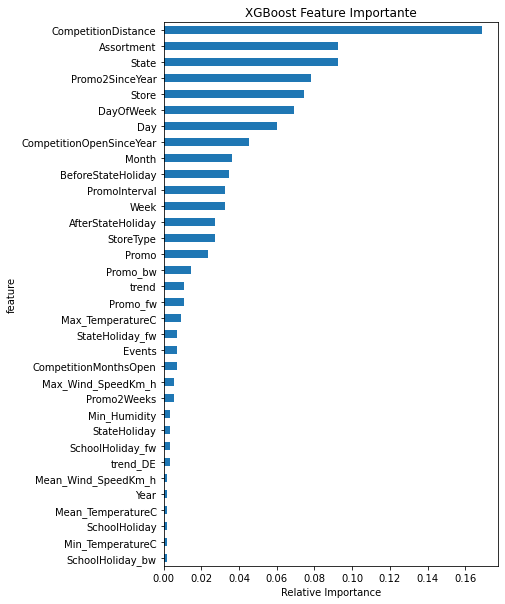

In [ ]:
importance = model_xg.get_fscore()
importante = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importante, columns=['feature', 'fscore'])
df['fscore'] = df['fscore']/df['fscore'].sum()

df.plot(kind = 'barh', x='feature', y='fscore', legend=False, figsize=(6,10))
plt.title('XGBoost Feature Importante')
plt.xlabel('Relative Importance')

In [ ]:
y_pred_train_log = model_xg.predict(xdata)
y_pred_val_log = model_xg.predict(xdata_val)

In [ ]:
y_pred_train = np.exp(y_pred_train_log*max_log_y)
y_pred_val = np.exp(y_pred_val_log*max_log_y)

In [ ]:
rmspe_train_log = rmspe(y_pred_train_log, y_train)
rmspe_val_log = rmspe(y_pred_val_log, y_valid)


In [ ]:
rmspe_train = rmspe(y_pred_train, y_train_orig)
rmspe_val = rmspe(y_pred_val, y_valid_orig)

In [ ]:
print(rmspe_train, rmspe_val)

0.6904072198085287 0.7003903296959888


In [ ]:
print(rmspe_train_log, rmspe_val_log)

0.13968447043972285 0.14288820699249205


In [ ]:
y_pred_val[1:5]

array([2026.8271, 1861.0042, 1835.4557, 1843.6774], dtype=float32)

In [ ]:
y_valid_orig[1:5]

Date
2015-05-02    12465
2015-05-02     6700
2015-05-02     7218
2015-05-02     6367
Name: Sales, dtype: int64